In [60]:
import codecs, re, os

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.model_selection import cross_validate


In [61]:
def load_speaker(path="../data/raw/corpus.tache1.learn.utf8"):
    corpus = []
    classes = []
    f = codecs.open(path, "r", "utf-8")  # pour régler le codage
    while True:
        texte = f.readline()
        if (len(texte)) < 5:
            break
        label = re.sub(r"<\d*:\d*:(.)>.*", "\\1", texte)
        texte = re.sub(r"<\d*:\d*:.>(.*)", "\\1", texte)
        if label.count("M") > 0:
            classes.append(-1)
        else:
            classes.append(1)
        corpus.append(texte)
    return np.array(corpus), np.array(classes)

X, y = load_speaker()
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [62]:
def nested_blocks(arr):
    blocks = []
    curr_block = []
    prev_val = None
    
    for val in arr:
        if val != prev_val:
            if curr_block:
                blocks.append(np.array(curr_block))
                curr_block = []
        curr_block.append(val)
        prev_val = val
    
    if curr_block:
        blocks.append(np.array(curr_block))
    
    return blocks

y_nested = nested_blocks(y)
[block for block in y_nested if np.all(block == 1)]
np.median([len(block) for block in y_nested if np.all(block == 1)])

80.0

In [63]:
len([block[0] for block in y_nested])

801

In [64]:
def nested_blocks(X, y):
    blocks = []
    curr_block = []
    prev_val = None
    change_points = [0]  # list of indices where a new block starts

    # iterate over the labels
    for i, val in enumerate(y):
        if val != prev_val:
            # if the value changes, start a new block
            if curr_block:
                blocks.append(
                    curr_block
                )  # add the previous block to the list of blocks
                curr_block = []  # reset the current block
                change_points.append(
                    i
                )  # add the index of the new block to the change points
        curr_block.append(val)  # add the current value to the current block
        prev_val = val  # set the previous value to the current value

    if curr_block:
        blocks.append(curr_block)  # add the last block to the list of block
        change_points.append(
            len(y)
        )  # add the index of the end of the array to the change points

    discours = []
    for block in blocks:
        # find the start and end indices of the current block in the original array
        start = y.tolist().index(block[0], change_points[blocks.index(block)])
        end = y.tolist().index(block[-1], start) + 1
        end = min(
            end, len(y)
        )  # make sure end is not larger than the length of the array
        # use the change points to get the corresponding lines from the lines array, 
        # and join them with spaces
        discours.append(
            " ".join(
                X[
                    change_points[blocks.index(block)] : change_points[
                        blocks.index(block) + 1
                    ]
                ]
            )
        )

    labels = [block[0] for block in blocks]

    assert len(discours) == len(labels)

    return discours, labels


X_nested, y_nested = nested_blocks(X_train, y_train)

## Comparing original vs oversampling vs undersampling vs balanced for our models


In [66]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay

sampler = ["original", "oversampling", "undersampling", "balanced weights", "balanced ++"] # "balanced + regularization"


def make_pipeline(mode, model):
    if mode == "original":
        return make_imb_pipeline(CountVectorizer(), model())
    elif mode == "oversampling":
        return make_imb_pipeline(CountVectorizer(), RandomOverSampler(), model())
    elif mode == "undersampling":
        return make_imb_pipeline(
            CountVectorizer(), RandomUnderSampler(replacement=False), model()
        )
    elif mode == "balanced weights" and model.__name__ != "MultinomialNB":
        return make_imb_pipeline(CountVectorizer(), model(class_weight="balanced"))
    elif mode == "balanced ++" and model.__name__ != "MultinomialNB":
        weights = {-1: 100000000, 1:1}
        return make_imb_pipeline(CountVectorizer(), model(class_weight=weights))
    elif "balanced" in mode and model.__name__ == "MultinomialNB":
        return make_imb_pipeline(CountVectorizer(), model(fit_prior=True))
    # elif mode == "balanced + regularization" and model.__name__ != "MultinomialNB":
    #     return make_imb_pipeline(CountVectorizer(), model(C=10))
    # elif mode == "balanced + regularization" and model.__name__ == "MultinomialNB":
    #     return make_imb_pipeline(CountVectorizer(), model(fit_prior=True, alpha=0.5))

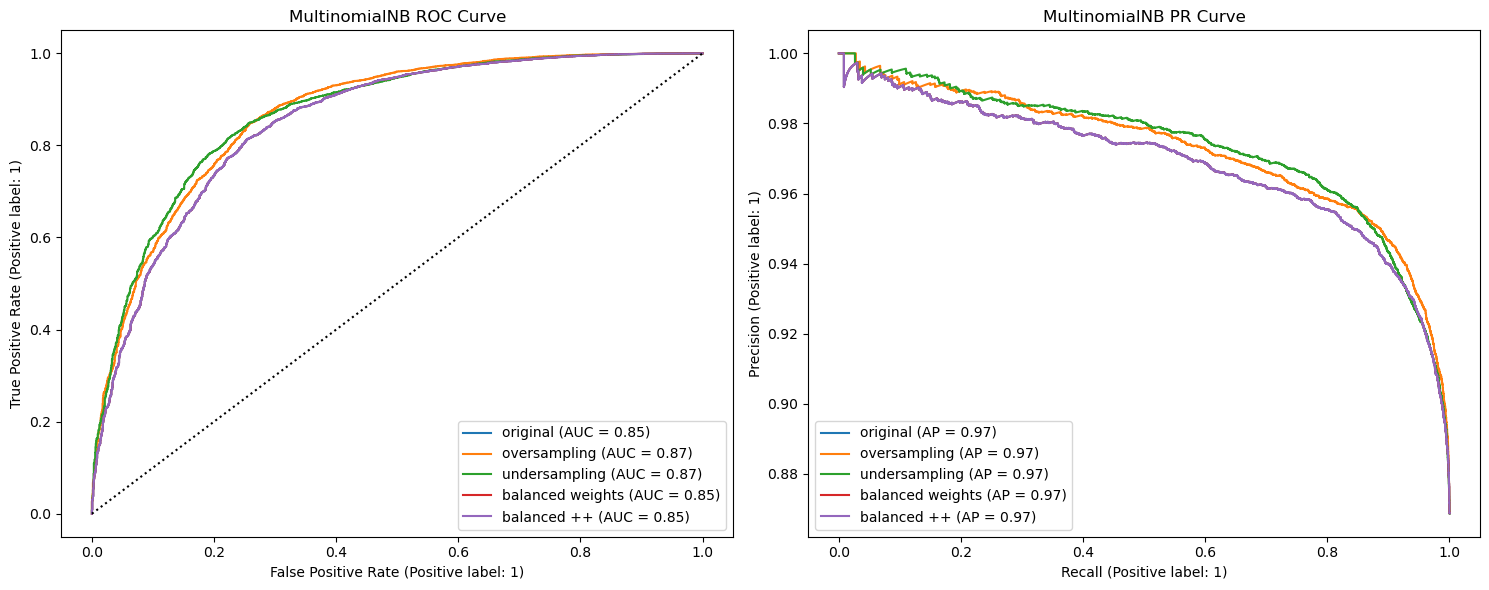

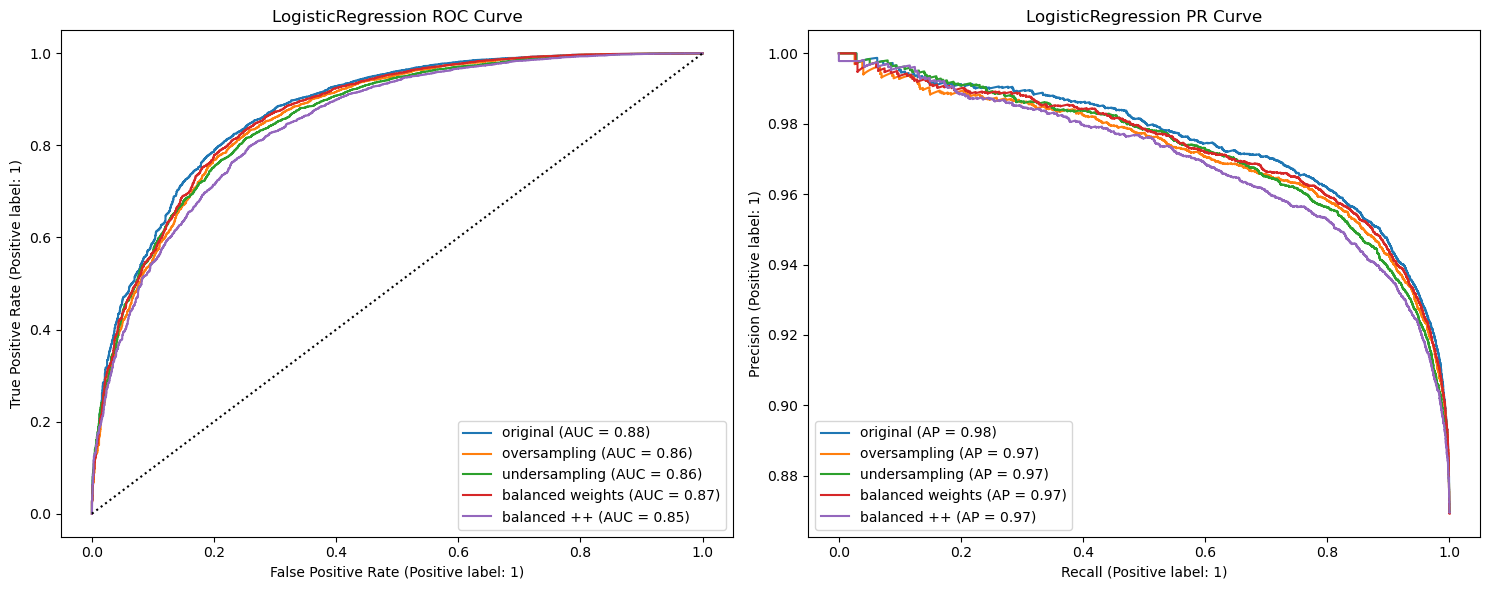

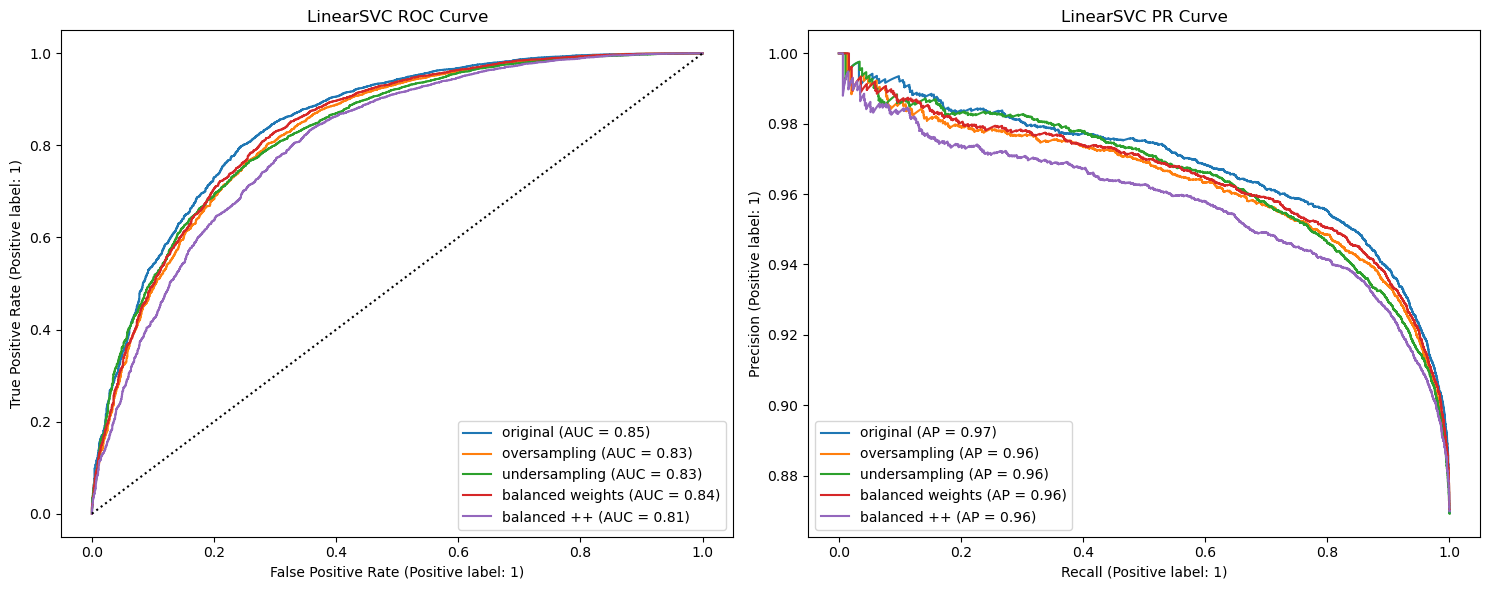

In [67]:
models = [MultinomialNB, LogisticRegression, LinearSVC]

for i, model in enumerate(models):
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    for sample in sampler:
        pipeline = make_pipeline(sample, model)
        pipeline.fit(X_train, y_train)
        RocCurveDisplay.from_estimator(pipeline, X_test, y_test, name=sample, ax=ax[0])
        PrecisionRecallDisplay.from_estimator(
            pipeline, X_test, y_test, name=sample, ax=ax[1]
        )
    ax[0].set_title(f"{model.__name__} ROC Curve")
    ax[0].plot([0, 1], [0, 1], "k:", label="(AUC = 0.5)")
    ax[1].set_title(f"{model.__name__} PR Curve")
    plt.tight_layout()
    plt.show()


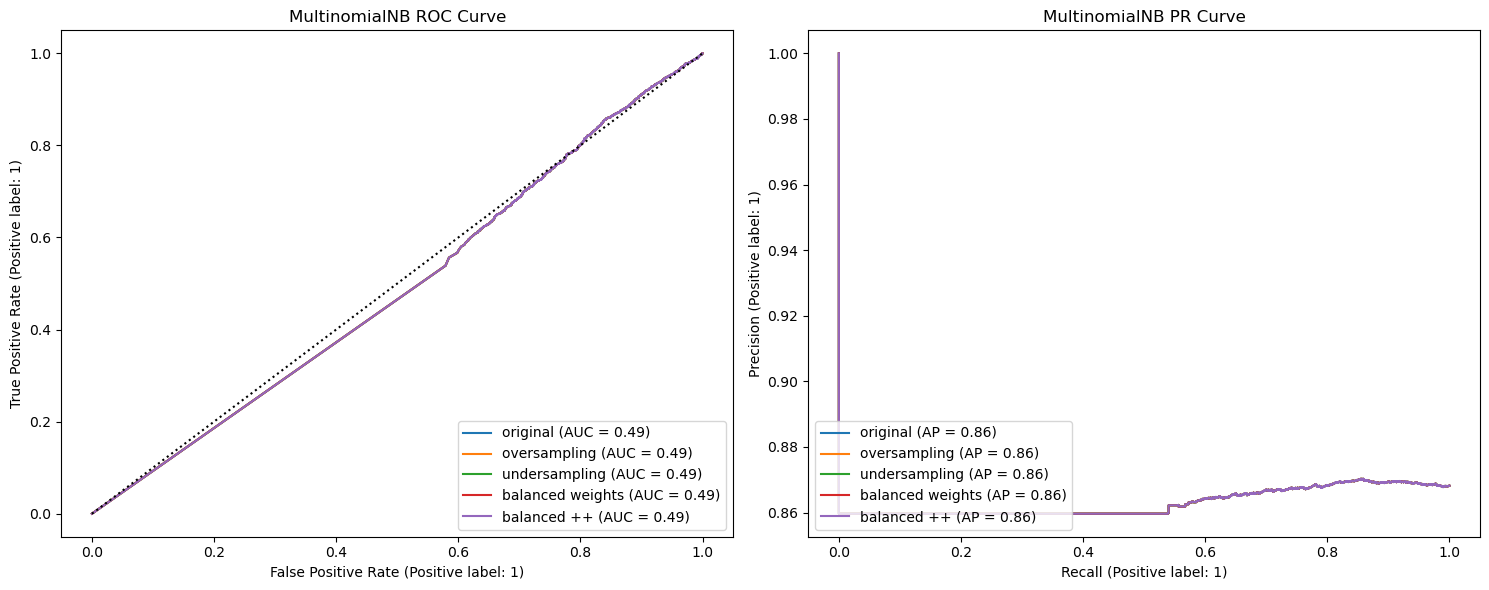

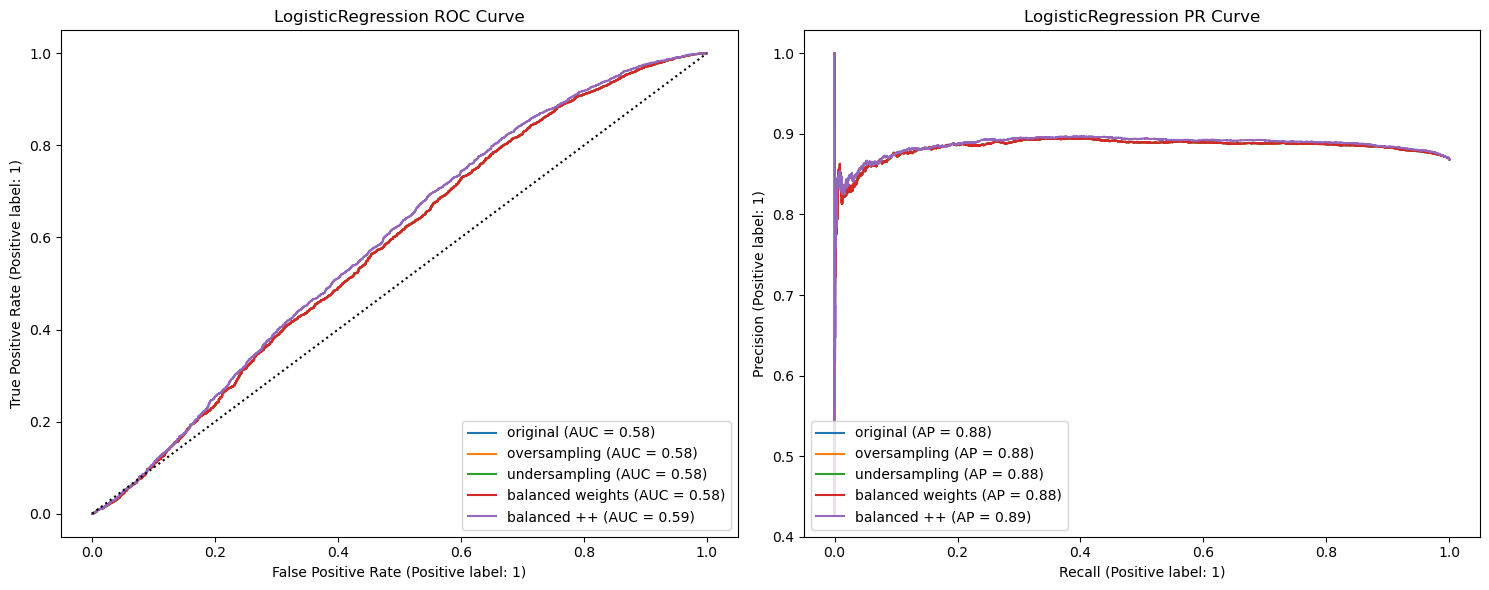

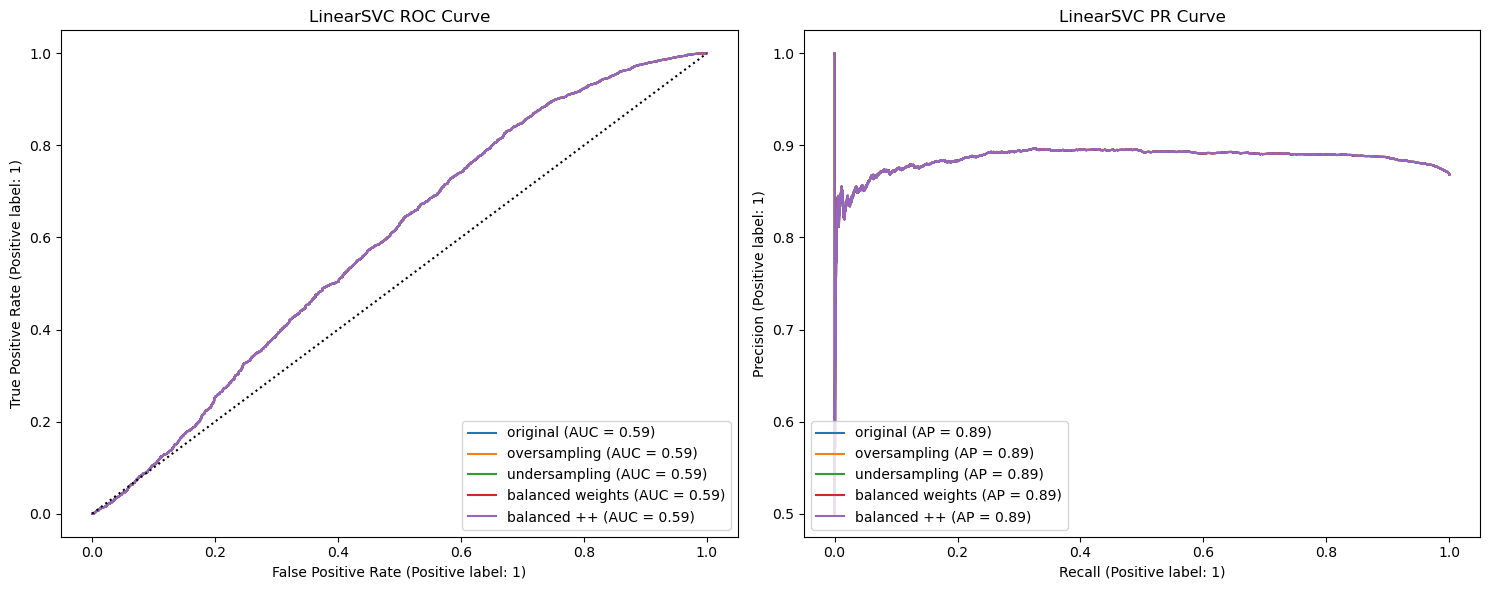

In [68]:
sampler = ["original", "balanced weights", "balanced ++"] # "balanced + regularization"


models = [MultinomialNB, LogisticRegression, LinearSVC]

for i, model in enumerate(models):
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    for sample in sampler:
        pipeline = make_pipeline(sample, model)
        pipeline.fit(X_nested, y_nested)
        RocCurveDisplay.from_estimator(pipeline, X_test, y_test, name=sample, ax=ax[0])
        PrecisionRecallDisplay.from_estimator(
            pipeline, X_test, y_test, name=sample, ax=ax[1]
        )
    ax[0].set_title(f"{model.__name__} ROC Curve")
    ax[0].plot([0, 1], [0, 1], "k:", label="(AUC = 0.5)")
    ax[1].set_title(f"{model.__name__} PR Curve")
    plt.tight_layout()
    plt.show()


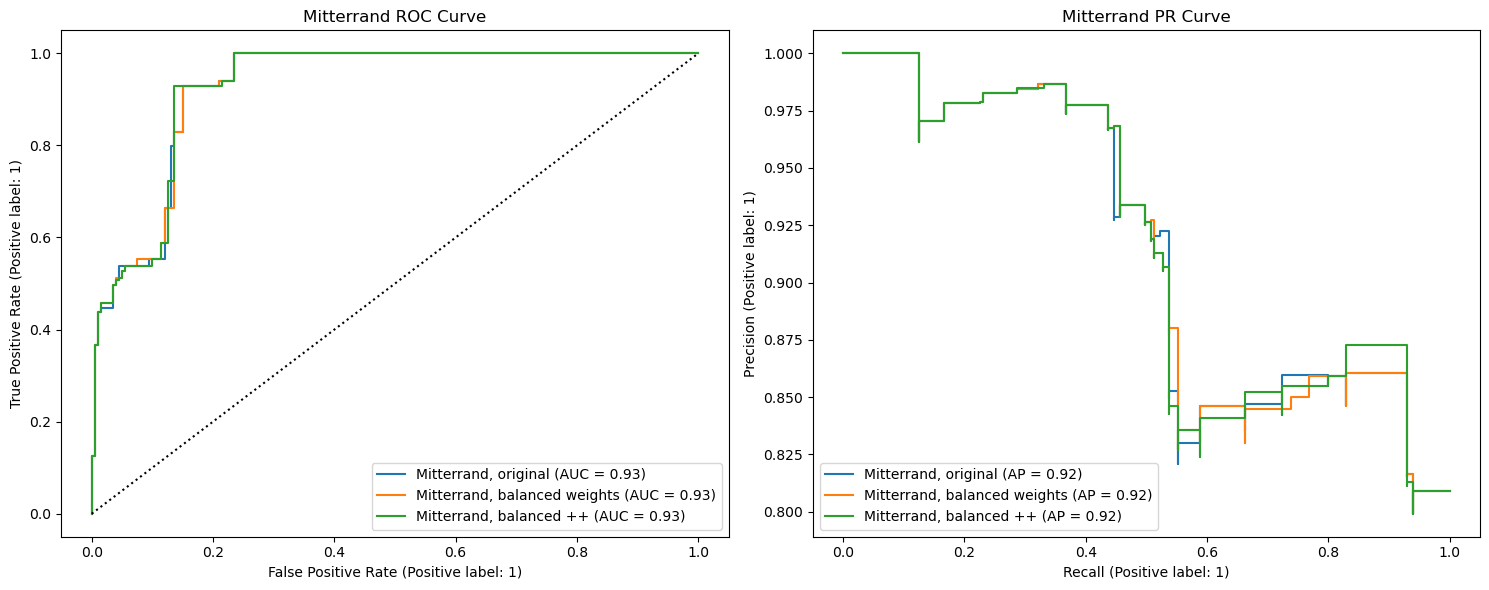

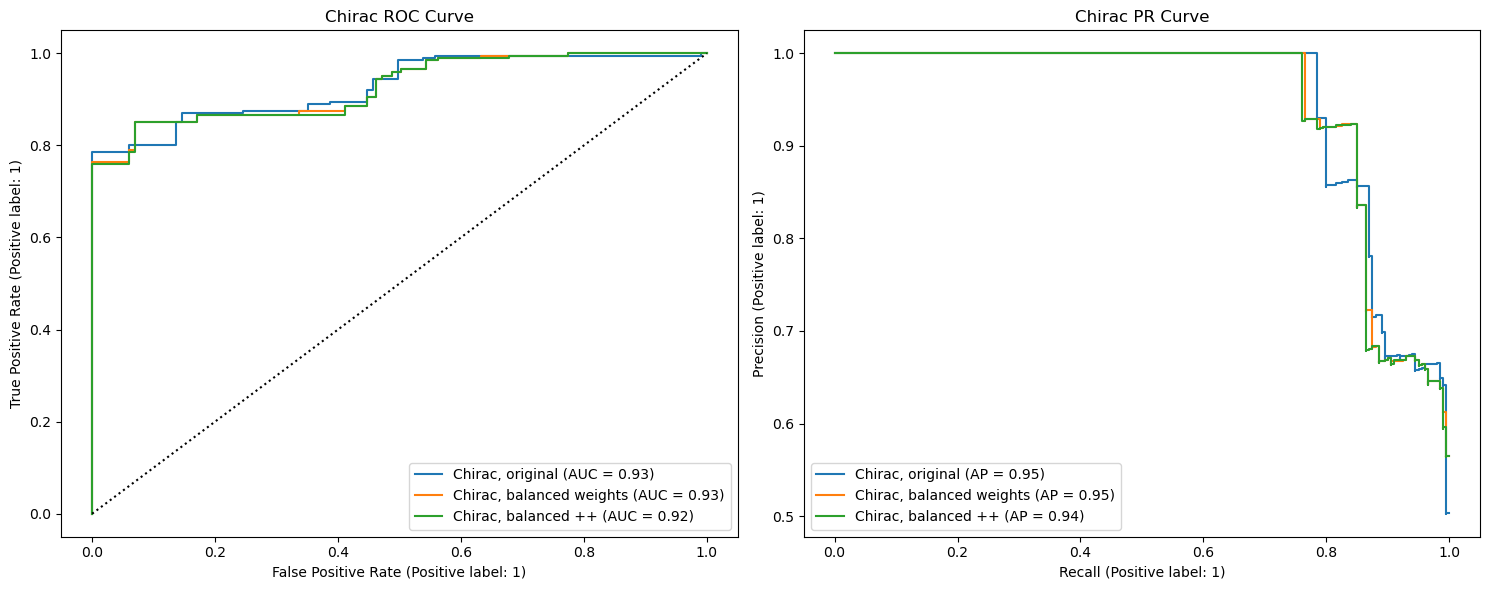

In [59]:
sampler = ["original", "balanced weights", "balanced ++"] # "balanced + regularization"

y_onehot_test = pd.get_dummies(y_test).to_numpy()

classes = ["Mitterrand", "Chirac"]
for class_id, class_name in enumerate(classes):
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    for sample in sampler:
        pipeline = make_imb_pipeline(CountVectorizer(), LogisticRegression(penalty="l1", solver="liblinear", class_weight="balanced"))
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict_proba(X_test)
        RocCurveDisplay.from_predictions(y_onehot_test[:,class_id], y_pred[:,class_id], name=f"{class_name}, {sample}", ax=ax[0])
        PrecisionRecallDisplay.from_predictions(y_onehot_test[:,class_id], y_pred[:,class_id], name=f"{class_name}, {sample}", ax=ax[1])
    ax[0].set_title(f"{class_name} ROC Curve")
    ax[0].plot([0, 1], [0, 1], "k:", label="(AUC = 0.5)")
    ax[1].set_title(f"{class_name} PR Curve")
    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

y_onehot_test = pd.get_dummies(y_test).to_numpy()

classes = ["Mitterrand", "Chirac"]
for class_id, class_name in enumerate(classes):
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    for sample in sampler:
        pipeline = make_imb_pipeline(CountVectorizer(), GradientBoostingClassifier())
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict_proba(X_test)
        RocCurveDisplay.from_predictions(y_onehot_test[:,class_id], y_pred[:,class_id], name=f"{class_name}, {sample}", ax=ax[0])
        PrecisionRecallDisplay.from_predictions(y_onehot_test[:,class_id], y_pred[:,class_id], name=f"{class_name}, {sample}", ax=ax[1])
    ax[0].set_title(f"{class_name} ROC Curve")
    ax[0].plot([0, 1], [0, 1], "k:", label="(AUC = 0.5)")
    ax[1].set_title(f"{class_name} PR Curve")
    plt.tight_layout()
    plt.show()

In [56]:
def load_movies(path="../../part2_review/data/raw/"):
    corpus = []
    classes = []
    label = 0
    for cl in os.listdir(path):  # parcours des fichiers d'un répertoire
        for f in os.listdir(path + cl):
            txt = open(path + cl + "/" + f).read()
            corpus.append(txt)
            classes.append(label)
        label += 1  # changer de répertoire <=> changement de classe
    return np.array(corpus), np.array(classes)

X, y = load_movies()
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
sampler = ["original", "oversampling", "undersampling", "balanced weights"]

models = [MultinomialNB, LogisticRegression, LinearSVC]

for i, model in enumerate(models):
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    for sample in sampler:
        pipeline = make_pipeline(sample, model)
        pipeline.fit(X_train, y_train)
        RocCurveDisplay.from_estimator(pipeline, X_test, y_test, name=sample, ax=ax[0])
        PrecisionRecallDisplay.from_estimator(
            pipeline, X_test, y_test, name=sample, ax=ax[1]
        )
    ax[0].set_title(f"{model.__name__} ROC Curve")
    ax[0].plot([0, 1], [0, 1], "k:", label="(AUC = 0.5)")
    ax[1].set_title(f"{model.__name__} PR Curve")
    plt.tight_layout()
    plt.show()